# Velib in Paris

Objectif : augmenter l’offre de stationnement vélo

-        Visualiser l’existant :  positionnement du stationnement vélo, nombre de place, densité à l’IRIS (Ilots Regroupés pour l’Information Statistique) et par arrondissement….
-        Identifier les principaux équipements et commerces qui ne présentent pas de stationnement vélo à proximité immédiate (moins de 50 mètres)  et éventuellement avoir une indication de la distance du stationnement le plus proche.
-        Identifier par zone (à l’IRIS ?/par arrondissement…)  le nombre actuel de place de stationnement vélo, et l’écart par rapport à la demande moyenne parisienne – sur la base des données INSEE à l’IRIS et de l’utilisation du système vélib ‘.

## Import

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [56]:
!pip install GeoPandas

     |████████████████████████████████| 1.0 MB 3.0 MB/s            
     |████████████████████████████████| 2.1 MB 74.0 MB/s            
     |████████████████████████████████| 5.8 MB 17.6 MB/s            
     |████████████████████████████████| 16.6 MB 34.6 MB/s            
You should consider upgrading via the '/home/romain/.pyenv/versions/3.8.12/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [72]:
import geopandas as gpd
import folium

### Import dataset

In [12]:
arrive = pd.read_excel('data/2021_S1_Stations_arrivees_Paris.xlsx')
arrive.head()

,Month_name,Unnamed: 1,Janvier,Février,Mars,Avril,Mai,Juin,Juillet
0,Code de la station,Arrivées par station,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs
1,0000002,Station Fermeture Système,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,René Boulanger - Lancry,4059,4218,4531,3830,4234,5890,5125
3,10003,Hauteville - Bonne Nouvelle,2563,2645,3337,2764,3999,5170,4126
4,10004,Metz - Faubourg Saint-Denis,5205,4899,6584,6421,7162,9054,7677


In [11]:
depart = pd.read_excel('data/2021_S1_Stations_departs_Paris.xlsx')
depart.head()

,Month_name,Unnamed: 1,Janvier,Février,Mars,Avril,Mai,Juin,Juillet
0,Code de la station,Départs par station,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs
1,10001,René Boulanger - Lancry,4059,4131,4517,3833,4181,5819,5008
2,10003,Hauteville - Bonne Nouvelle,2513,2611,3384,2759,3932,5128,4108
3,10004,Metz - Faubourg Saint-Denis,5172,4814,6412,6312,7063,8965,7655
4,10005,Petites Ecuries - Faubourg Poissonnière,2949,2891,3856,3259,3845,5147,4032


In [10]:
emplacement = pd.read_csv('data/velib-emplacement-des-stations.csv', sep=';')
emplacement.head()

,Identifiant station,Nom de la station,Capacité de la station,Coordonnées géographiques
0,11025,Froment - Bréguet,43,"48.8570414504784,2.37289470306807"
1,6029,Vaugirard - Monsieur le Prince,26,"48.848951441614176,2.3411329463124275"
2,7025,Octave Gréard - Tour Eiffel,33,"48.856502977695634,2.293178754328878"
3,9028,Moncey - Blanche,17,"48.88006587474148,2.3310810327529907"
4,10042,Enghien - Faubourg Poissonnière,16,"48.87242006305313,2.348395236282807"


In [207]:
real_time = pd.read_csv('data/velib_disponibilite_en_temps_reel.csv', sep=';')

In [211]:
real_time = real_time[['Identifiant station', 'Vélos mécaniques disponibles', 'Vélos électriques disponibles']]
real_time.columns = ['station_id', 'mecanique_dispo_nb', 'electrique_dispo_nb']
real_time.head()

,station_id,mecanique_dispo_nb,electrique_dispo_nb
0,9020,0,0
1,16107,2,2
2,12109,18,5
3,11104,0,1
4,6003,6,6


## Datasets modifs

### Emplacement

In [17]:
emplacement['Coordonnées géographiques'][0].split(',')[0]

'48.8570414504784'

In [53]:
emplacement['lat'] = emplacement['Coordonnées géographiques'].apply(lambda x: float(x.split(',')[0]))
emplacement['lon'] = emplacement['Coordonnées géographiques'].apply(lambda x: float(x.split(',')[1]))

In [198]:
emplacement.columns = ['station_id', 'station_name', 'station_capacity', 'Coordonnées géographiques', 'lat', 'lon']

In [199]:
emplacement.head()

,station_id,station_name,station_capacity,Coordonnées géographiques,lat,lon
0,11025,Froment - Bréguet,43,"48.8570414504784,2.37289470306807",48.857041,2.372895
1,6029,Vaugirard - Monsieur le Prince,26,"48.848951441614176,2.3411329463124275",48.848951,2.341133
2,7025,Octave Gréard - Tour Eiffel,33,"48.856502977695634,2.293178754328878",48.856503,2.293179
3,9028,Moncey - Blanche,17,"48.88006587474148,2.3310810327529907",48.880066,2.331081
4,10042,Enghien - Faubourg Poissonnière,16,"48.87242006305313,2.348395236282807",48.872420,2.348395


In [55]:
emplacement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1439 entries, 0 to 1438
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Identifiant station        1439 non-null   object 
 1   Nom de la station          1439 non-null   object 
 2   Capacité de la station     1439 non-null   int64  
 3   Coordonnées géographiques  1439 non-null   object 
 4   lat                        1439 non-null   float64
 5   lon                        1439 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 67.6+ KB


### Arrive

In [107]:
arrive.head()

,Month_name,Unnamed: 1,Janvier,Février,Mars,Avril,Mai,Juin,Juillet
0,Code de la station,Arrivées par station,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs
1,0000002,Station Fermeture Système,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,René Boulanger - Lancry,4059,4218,4531,3830,4234,5890,5125
3,10003,Hauteville - Bonne Nouvelle,2563,2645,3337,2764,3999,5170,4126
4,10004,Metz - Faubourg Saint-Denis,5205,4899,6584,6421,7162,9054,7677


In [125]:
arrive.columns = ['station_id', 'station_nom', 'Janvier_arrive', 'Février_arrive', 'Mars_arrive', 'Avril_arrive', 'Mai_arrive', 'Juin_arrive', 'Juillet_arrive']

In [126]:
arrive_df = arrive.drop(axis=1, index=[0,1])
arrive_df

,station_id,station_nom,Janvier_arrive,Février_arrive,Mars_arrive,Avril_arrive,Mai_arrive,Juin_arrive,Juillet_arrive
2,10001,René Boulanger - Lancry,4059,4218,4531,3830,4234,5890,5125
3,10003,Hauteville - Bonne Nouvelle,2563,2645,3337,2764,3999,5170,4126
4,10004,Metz - Faubourg Saint-Denis,5205,4899,6584,6421,7162,9054,7677
5,10005,Petites Ecuries - Faubourg Poissonnière,2987,2935,3846,3332,3890,5202,4073
6,10006,Petites Ecuries - Faubourg Saint-Denis,6301,5862,7537,6939,8200,10811,9021
...,...,...,...,...,...,...,...,...,...
1005,9116,Victoire - Chaussée d'Antin,1420,1233,1484,1366,1617,2281,2169
1006,9117,Bellefond - Maubeuge,1570,1412,1839,1518,1756,2269,1589
1007,9118,Faubourg Poissonniere - Delta,1653,1562,1889,2146,2036,2473,1877
1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### depart

In [119]:
depart.head()

,station_id,station_nom,Janvier,Février,Mars,Avril,Mai,Juin,Juillet
0,Code de la station,Départs par station,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs,Valeurs
1,10001,René Boulanger - Lancry,4059,4131,4517,3833,4181,5819,5008
2,10003,Hauteville - Bonne Nouvelle,2513,2611,3384,2759,3932,5128,4108
3,10004,Metz - Faubourg Saint-Denis,5172,4814,6412,6312,7063,8965,7655
4,10005,Petites Ecuries - Faubourg Poissonnière,2949,2891,3856,3259,3845,5147,4032


In [127]:
depart.columns = ['station_id', 'station_nom', 'Janvier_depart', 'Février_depart', 'Mars_depart', 'Avril_depart', 'Mai_depart', 'Juin_depart', 'Juillet_depart']

In [128]:
depart_df = depart.drop(axis=1, index=0)
depart_df

,station_id,station_nom,Janvier_depart,Février_depart,Mars_depart,Avril_depart,Mai_depart,Juin_depart,Juillet_depart
1,10001,René Boulanger - Lancry,4059,4131,4517,3833,4181,5819,5008
2,10003,Hauteville - Bonne Nouvelle,2513,2611,3384,2759,3932,5128,4108
3,10004,Metz - Faubourg Saint-Denis,5172,4814,6412,6312,7063,8965,7655
4,10005,Petites Ecuries - Faubourg Poissonnière,2949,2891,3856,3259,3845,5147,4032
5,10006,Petites Ecuries - Faubourg Saint-Denis,6317,5823,7567,6822,8111,10832,8971
...,...,...,...,...,...,...,...,...,...
1002,9116,Victoire - Chaussée d'Antin,1433,1216,1468,1331,1579,2263,2169
1003,9117,Bellefond - Maubeuge,1659,1474,1859,1640,1857,2317,1619
1004,9118,Faubourg Poissonniere - Delta,1626,1563,1957,2225,2144,2561,1856
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Stations sur map

In [240]:
map_osm = folium.Map(location=[48.85, 2.34])
# folium.Marker(emplacement['Coordonnées géographiques'][0].split(','), popup=emplacement['Nom de la station'][0]).add_to(map_osm)
for point in range(0, len(emplacement['Coordonnées géographiques'])):
    folium.Marker(emplacement['Coordonnées géographiques'][point].split(','), popup=emplacement['station_name'][point]).add_to(map_osm)
map_osm

## Velib stations

In [129]:
arrive_df.head()

,station_id,station_nom,Janvier_arrive,Février_arrive,Mars_arrive,Avril_arrive,Mai_arrive,Juin_arrive,Juillet_arrive
2,10001,René Boulanger - Lancry,4059,4218,4531,3830,4234,5890,5125
3,10003,Hauteville - Bonne Nouvelle,2563,2645,3337,2764,3999,5170,4126
4,10004,Metz - Faubourg Saint-Denis,5205,4899,6584,6421,7162,9054,7677
5,10005,Petites Ecuries - Faubourg Poissonnière,2987,2935,3846,3332,3890,5202,4073
6,10006,Petites Ecuries - Faubourg Saint-Denis,6301,5862,7537,6939,8200,10811,9021


In [130]:
depart_df.head()

,station_id,station_nom,Janvier_depart,Février_depart,Mars_depart,Avril_depart,Mai_depart,Juin_depart,Juillet_depart
1,10001,René Boulanger - Lancry,4059,4131,4517,3833,4181,5819,5008
2,10003,Hauteville - Bonne Nouvelle,2513,2611,3384,2759,3932,5128,4108
3,10004,Metz - Faubourg Saint-Denis,5172,4814,6412,6312,7063,8965,7655
4,10005,Petites Ecuries - Faubourg Poissonnière,2949,2891,3856,3259,3845,5147,4032
5,10006,Petites Ecuries - Faubourg Saint-Denis,6317,5823,7567,6822,8111,10832,8971


In [135]:
velibs_df = arrive_df.merge(depart_df, how='inner', on=['station_id', 'station_nom']).dropna()

In [136]:
velibs_df.head(1)

,station_id,station_nom,Janvier_arrive,Février_arrive,Mars_arrive,Avril_arrive,Mai_arrive,Juin_arrive,Juillet_arrive,Janvier_depart,Février_depart,Mars_depart,Avril_depart,Mai_depart,Juin_depart,Juillet_depart
0,10001,René Boulanger - Lancry,4059,4218,4531,3830,4234,5890,5125,4059,4131,4517,3833,4181,5819,5008


In [142]:
velibs_df['Janvier_diff'] = velibs_df['Janvier_arrive'] - velibs_df['Janvier_depart']
velibs_df['Février_diff'] = velibs_df['Février_arrive'] - velibs_df['Février_depart']
velibs_df['Mars_diff'] = velibs_df['Mars_arrive'] - velibs_df['Mars_depart']
velibs_df['Avril_diff'] = velibs_df['Avril_arrive'] - velibs_df['Avril_depart']
velibs_df['Mai_diff'] = velibs_df['Mai_arrive'] - velibs_df['Mai_depart']
velibs_df['Juin_diff'] = velibs_df['Juin_arrive'] - velibs_df['Juin_depart']
velibs_df['Juillet_diff'] = velibs_df['Juillet_arrive'] - velibs_df['Juillet_depart']

In [241]:
velibs_df.head()

,station_id,station_nom,Janvier_arrive,Février_arrive,Mars_arrive,Avril_arrive,Mai_arrive,Juin_arrive,Juillet_arrive,Janvier_depart,...,Juin_depart,Juillet_depart,Janvier_diff,Février_diff,Mars_diff,Avril_diff,Mai_diff,Juin_diff,Juillet_diff,diff_mean
0,10001,René Boulanger - Lancry,4059,4218,4531,3830,4234,5890,5125,4059,...,5819,5008,0,87,14,-3,53,71,117,48
1,10003,Hauteville - Bonne Nouvelle,2563,2645,3337,2764,3999,5170,4126,2513,...,5128,4108,50,34,-47,5,67,42,18,24
2,10004,Metz - Faubourg Saint-Denis,5205,4899,6584,6421,7162,9054,7677,5172,...,8965,7655,33,85,172,109,99,89,22,87
3,10005,Petites Ecuries - Faubourg Poissonnière,2987,2935,3846,3332,3890,5202,4073,2949,...,5147,4032,38,44,-10,73,45,55,41,40
4,10006,Petites Ecuries - Faubourg Saint-Denis,6301,5862,7537,6939,8200,10811,9021,6317,...,10832,8971,-16,39,-30,117,89,-21,50,32


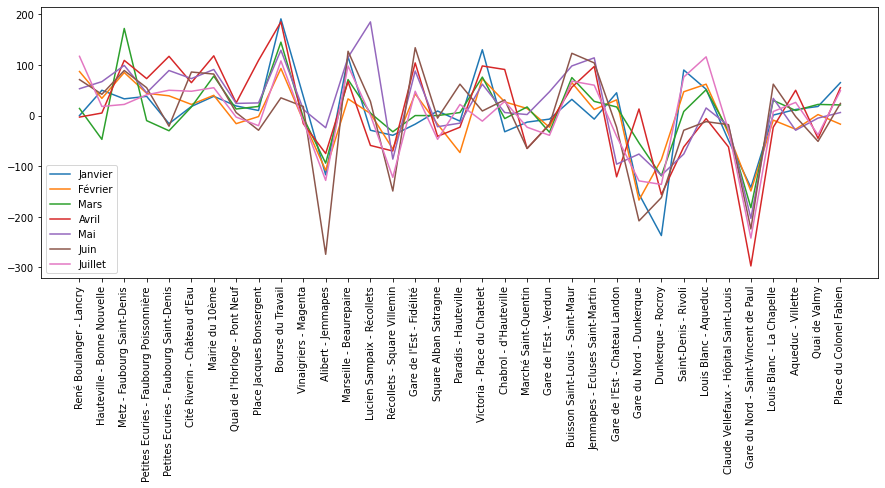

In [235]:
plt.figure(figsize=(15,5))
plt.plot(velibs_df['station_nom'][0:35], velibs_df['Janvier_diff'][0:35], label='Janvier')
plt.plot(velibs_df['station_nom'][0:35], velibs_df['Février_diff'][0:35], label='Février')
plt.plot(velibs_df['station_nom'][0:35], velibs_df['Mars_diff'][0:35], label='Mars')
plt.plot(velibs_df['station_nom'][0:35], velibs_df['Avril_diff'][0:35], label='Avril')
plt.plot(velibs_df['station_nom'][0:35], velibs_df['Mai_diff'][0:35], label='Mai')
plt.plot(velibs_df['station_nom'][0:35], velibs_df['Juin_diff'][0:35], label='Juin')
plt.plot(velibs_df['station_nom'][0:35], velibs_df['Juillet_diff'][0:35], label='Juillet')
plt. xticks(rotation=90)
plt.legend();

In [177]:
velibs_df.to_csv('data/velibs_df.csv')

In [183]:
velibs_df[['Janvier_diff', 'Février_diff', 'Mars_diff', 'Avril_diff', 'Mai_diff', 'Juin_diff', 'Juillet_diff']][0:1]

,Janvier_diff,Février_diff,Mars_diff,Avril_diff,Mai_diff,Juin_diff,Juillet_diff
0,0,87,14,-3,53,71,117


In [190]:
velibs_df['diff_mean'] = np.mean(velibs_df[['Janvier_diff', 'Février_diff', 'Mars_diff', 'Avril_diff', 'Mai_diff', 'Juin_diff', 'Juillet_diff']], axis=1).apply(lambda x: int(x))

In [229]:
velibs_stations = velibs_df[['station_id', 'station_nom', 'diff_mean']].merge(emplacement[['station_id', 'station_capacity', 'Coordonnées géographiques', 'lat', 'lon']], how='inner', on='station_id')

In [205]:
velibs_stations.to_csv('data/velibs_stations.csv')

In [230]:
velibs_stations = velibs_stations.merge(real_time, how='left', on='station_id')

In [231]:
velibs_stations

,station_id,station_nom,diff_mean,station_capacity,Coordonnées géographiques,lat,lon,mecanique_dispo_nb,electrique_dispo_nb
0,10001,René Boulanger - Lancry,48,62,"48.8685433,2.3600032",48.868543,2.360003,22,21
1,10003,Hauteville - Bonne Nouvelle,24,17,"48.87077436024043,2.349649636832728",48.870774,2.349650,3,1
2,10004,Metz - Faubourg Saint-Denis,87,48,"48.870893,2.353521",48.870893,2.353521,7,5
3,10005,Petites Ecuries - Faubourg Poissonnière,40,18,"48.87397217237368,2.348388757504776",48.873972,2.348389,1,3
4,10006,Petites Ecuries - Faubourg Saint-Denis,32,28,"48.87287120589831,2.3542150855064397",48.872871,2.354215,1,1
...,...,...,...,...,...,...,...,...,...
966,9114,Faubourg Poissonnière - Dunkerque,-214,30,"48.880883445404436,2.349934279918671",48.880883,2.349934,1,0
967,9115,Milton - Manuel,-24,22,"48.878249,2.341181",48.878249,2.341181,0,0
968,9116,Victoire - Chaussée d'Antin,15,24,"48.875065791004396,2.3316738009452824",48.875066,2.331674,5,0
969,9117,Bellefond - Maubeuge,-67,31,"48.878255397644715,2.345264218747616",48.878255,2.345264,1,0


In [232]:
velibs_stations['mecanique_ratio'] = round(velibs_stations['mecanique_dispo_nb'] / (velibs_stations['electrique_dispo_nb'] + velibs_stations['mecanique_dispo_nb']), 2)
velibs_stations['electrique_ratio'] = round(velibs_stations['electrique_dispo_nb'] / (velibs_stations['electrique_dispo_nb'] + velibs_stations['mecanique_dispo_nb']), 2)

In [233]:
velibs_stations

,station_id,station_nom,diff_mean,station_capacity,Coordonnées géographiques,lat,lon,mecanique_dispo_nb,electrique_dispo_nb,mecanique_ratio,electrique_ratio
0,10001,René Boulanger - Lancry,48,62,"48.8685433,2.3600032",48.868543,2.360003,22,21,0.51,0.49
1,10003,Hauteville - Bonne Nouvelle,24,17,"48.87077436024043,2.349649636832728",48.870774,2.349650,3,1,0.75,0.25
2,10004,Metz - Faubourg Saint-Denis,87,48,"48.870893,2.353521",48.870893,2.353521,7,5,0.58,0.42
3,10005,Petites Ecuries - Faubourg Poissonnière,40,18,"48.87397217237368,2.348388757504776",48.873972,2.348389,1,3,0.25,0.75
4,10006,Petites Ecuries - Faubourg Saint-Denis,32,28,"48.87287120589831,2.3542150855064397",48.872871,2.354215,1,1,0.50,0.50
...,...,...,...,...,...,...,...,...,...,...,...
966,9114,Faubourg Poissonnière - Dunkerque,-214,30,"48.880883445404436,2.349934279918671",48.880883,2.349934,1,0,1.00,0.00
967,9115,Milton - Manuel,-24,22,"48.878249,2.341181",48.878249,2.341181,0,0,NaN,NaN
968,9116,Victoire - Chaussée d'Antin,15,24,"48.875065791004396,2.3316738009452824",48.875066,2.331674,5,0,1.00,0.00
969,9117,Bellefond - Maubeuge,-67,31,"48.878255397644715,2.345264218747616",48.878255,2.345264,1,0,1.00,0.00


In [234]:
velibs_stations.to_csv('data/velibs_stations_2.csv')